In [268]:
# Let's read in our document-term matrix
import pandas as pd
import pickle
from collections import defaultdict
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Import the necessary modules for LDA with gensim
# Terminal / Anaconda Navigator: conda install -c conda-forge gensim
from gensim import matutils, models, corpora
from gensim.models.phrases import Phrases, Phraser
import scipy.sparse
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize, pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import spacy
nlp = spacy.load('en_core_web_sm')

dtm = pd.read_pickle('data_files/comedian_dtm')
raw_data = pd.read_pickle('data_files/comedian_corpus')
my_stop_words = pd.read_pickle('data_files/stop_words')

In [269]:
import pyLDAvis
from pyLDAvis import gensim_models
import warnings
warnings.filterwarnings('ignore')

# Topic Modelling
To attempt our topic modeling we'll be using a BoW model via sklearn, nltk and gensim. We will search our documents for linked words ('topics') and then assign our documents a score of how much the document relates to each of these topics.

# Attempt 1

In [270]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(dtm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [271]:
cv = CountVectorizer(stop_words = my_stop_words)
data_cv = cv.fit(raw_data.sketch_text)
id2word = dict((v, k) for k, v in data_cv.vocabulary_.items())

In [272]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
lda = models.LdaModel(corpus=corpus, id2word = id2word, num_topics=2, passes=20)
lda.print_topics()

[(0,
  '0.006*"uh" + 0.005*"okay" + 0.005*"love" + 0.004*"stuff" + 0.004*"good" + 0.004*"theres" + 0.004*"want" + 0.004*"funny" + 0.004*"god" + 0.004*"hey"'),
 (1,
  '0.008*"fucking" + 0.008*"going" + 0.006*"went" + 0.004*"want" + 0.004*"old" + 0.004*"fuck" + 0.004*"come" + 0.004*"good" + 0.004*"ill" + 0.004*"day"')]

In [273]:
lda = models.LdaModel(corpus=corpus, id2word = id2word, num_topics=4, passes=20)
lda.print_topics()

[(0,
  '0.008*"fucking" + 0.007*"funny" + 0.006*"going" + 0.004*"mate" + 0.004*"shite" + 0.004*"ill" + 0.004*"kevin" + 0.003*"big" + 0.003*"need" + 0.003*"night"'),
 (1,
  '0.009*"fucking" + 0.007*"going" + 0.006*"went" + 0.005*"good" + 0.005*"come" + 0.005*"fuckin" + 0.004*"mate" + 0.004*"want" + 0.004*"fuck" + 0.003*"need"'),
 (2,
  '0.007*"okay" + 0.007*"going" + 0.006*"fucking" + 0.005*"went" + 0.005*"want" + 0.005*"old" + 0.005*"uh" + 0.005*"didnt" + 0.004*"mean" + 0.004*"look"'),
 (3,
  '0.007*"hey" + 0.005*"love" + 0.005*"shit" + 0.005*"thank" + 0.004*"want" + 0.004*"fuck" + 0.004*"stuff" + 0.004*"okay" + 0.004*"good" + 0.004*"come"')]

In [274]:
lda = models.LdaModel(corpus=corpus, id2word = id2word, num_topics=6, passes=20)
lda.print_topics()

[(0,
  '0.010*"fucking" + 0.010*"going" + 0.008*"went" + 0.007*"mate" + 0.005*"shite" + 0.004*"fuck" + 0.004*"good" + 0.004*"ill" + 0.004*"come" + 0.004*"wee"'),
 (1,
  '0.000*"going" + 0.000*"fucking" + 0.000*"want" + 0.000*"good" + 0.000*"went" + 0.000*"old" + 0.000*"come" + 0.000*"love" + 0.000*"need" + 0.000*"look"'),
 (2,
  '0.012*"fucking" + 0.008*"going" + 0.006*"went" + 0.006*"want" + 0.006*"okay" + 0.005*"fuck" + 0.005*"god" + 0.004*"good" + 0.004*"come" + 0.004*"theres"'),
 (3,
  '0.009*"funny" + 0.008*"bo" + 0.007*"love" + 0.006*"want" + 0.005*"stuff" + 0.005*"um" + 0.004*"thank" + 0.004*"repeat" + 0.004*"make" + 0.004*"good"'),
 (4,
  '0.008*"hey" + 0.005*"okay" + 0.005*"shit" + 0.004*"kind" + 0.004*"thank" + 0.004*"day" + 0.004*"come" + 0.004*"good" + 0.004*"god" + 0.004*"shes"'),
 (5,
  '0.008*"uh" + 0.006*"going" + 0.006*"okay" + 0.005*"years" + 0.005*"old" + 0.005*"new" + 0.004*"look" + 0.004*"day" + 0.004*"lets" + 0.004*"hey"')]

These aren't very coherent topics, with two main issues:
- The topic is picking up a word that isn't mentioned that often such as 'yeahhhhhhh'
- The majority of the words in our topic are still too generic 

To solve these problems, I will:
- Remove any words from my corpus that only appear once, as they add minimal input to my topics
- Look to lemmatize my raw texts before creating my document term matrix
- Try splitting the sketches into segments

In [282]:
pattern = "[\w'.]+|[£|$0-9]+"
tokenizer = RegexpTokenizer(pattern)
def tokenize_text(text):
    return tokenizer.tokenize(text) 

In [283]:
split_sketches = pd.DataFrame()
for i in range(0,15):
    tokenized_text = tokenize_text(raw_data.sketch_text[i])
    total_len = len(tokenized_text)
    chunks = [math.floor(total_len/3), math.floor(2 * total_len / 3), total_len]
    new_index = [raw_data.index[i] + ' ' + str(0), raw_data.index[i] + ' ' + str(1), raw_data.index[i] + ' ' + str(2)]
    new_tok_text = [tokenized_text[0 : chunks[0]], tokenized_text[chunks[0] + 1 : chunks[1]], tokenized_text[chunks[1] + 1 : chunks[2]]]
    new_texts = [' '.join(new_tok_text[0]), ' '.join(new_tok_text[1]), ' '.join(new_tok_text[2])]
    temp_df = pd.DataFrame(new_texts, index = new_index, columns = ['split_sketch_text'])
    split_sketches = pd.concat([split_sketches, temp_df])

In [284]:
split_sketches.head()

,split_sketch_text
Bo Burnham - Words Words Words 0,thank you when i say hey you say ho hey ho hey...
Bo Burnham - Words Words Words 1,mic before electricity way back in b c e thats...
Bo Burnham - Words Words Words 2,name heres a fun one one of the every u s pres...
Bo Burnham - What 0,bo what old macdonald had a farm e i e i o and...
Bo Burnham - What 1,each other more then two people could possible...


In [285]:
lemmatizer = WordNetLemmatizer()
def lemmatize(list_of_text):
    text = [lemmatizer.lemmatize(word) for word in list_of_text]
    return text

In [286]:
my_stop_words = my_stop_words + ['uh','um','fu','jj']
def remove_stops(list_of_text):
    text = [word for word in list_of_text if word not in my_stop_words]
    return text

In [287]:
def nlp_pipeline(text):
    text = tokenize_text(text)
    text = remove_stops(text)
    text = lemmatize(text)
    text = ' '.join(text)
    return text

In [288]:
def unigrams(df, col_name, min_number):
    tokenized_docs = df[col_name].apply(lambda x: tokenize_text(x))
    frequency = defaultdict(int)
    for doc in tokenized_docs:
        for token in doc:
            frequency[token] +=1
    processed_tokens = [[token for token in doc if frequency[token] > min_number] for doc in tokenized_docs]
    return processed_tokens

In [289]:
def bigrams(df, col_name, min_number_b):
    tokenized_docs = df[col_name].apply(lambda x: tokenize_text(x))
    input_tokens = [doc for doc in tokenized_docs]
    bigram_model = Phraser(Phrases(input_tokens, min_count = min_number_b, threshold = min_number_b, delimiter = b' '))
    bigram_tokens = []
    for doc_tokens in input_tokens:
        bigram_tokens.append(bigram_model[doc_tokens])
    return bigram_model, bigram_tokens

In [290]:
def ngrams(df, col_name, min_number, min_number_b):
    # Create dict and bow cased on unigrams only
    processed_unigrams = unigrams(df, col_name, min_number)
    dictionary = corpora.Dictionary(processed_unigrams)
    bow_corpus = [dictionary.doc2bow(text) for text in processed_unigrams]
    
    # Add in bigrams to the model
    bigram_model, bigram_tokens = bigrams(df, col_name, min_number_b)
    dictionary.add_documents(bigram_tokens)
    bow_corpus = [dictionary.doc2bow(text) for text in bigram_model[processed_unigrams]]
    return dictionary, bow_corpus

In [291]:
def lda_model(corpus, dictionary, num_topics, random_state  = 100):
    lda_model = models.LdaMulticore(corpus = corpus, id2word = dictionary, num_topics = num_topics, random_state = random_state, passes = 20)
    return lda_model

In [292]:
def print_topic_keywords(lda_model, dictionary, num_topics):
    topics = []
    for n in range(num_topics):
        topics.append([])
        
    for topic_count in range(0, num_topics):
        for topic_term in lda_model.get_topic_terms(topic_count):
            topics[topic_count].append(dictionary.id2token[topic_term[0]])
            
    for counter, topic in enumerate(topics):
        print(f'Topic {counter}: {topic}')

In [293]:
def model_prep(df, col_name, min_number, min_number_b):
    df['prepped_text'] = df[col_name].apply(lambda x: nlp_pipeline(x))
    dictionary, bow_corpus = ngrams(df, 'prepped_text', min_number, min_number_b)
    return dictionary, bow_corpus
lda_dict, lda_corpus = model_prep(split_sketches, 'split_sketch_text', 1, 2)

In [294]:
num_topics = 2
lda_model_output = lda_model(corpus = lda_corpus, dictionary = lda_dict, num_topics = num_topics)
print_topic_keywords(lda_model_output, lda_dict, num_topics)

Topic 0: ['went', 'going', 'fucking', 'want', 'day', 'look', 'god', 'okay', 'mean', 'good']
Topic 1: ['fucking', 'going', 'come', 'day', 'okay', 'look', 'want', 'fuck', 'good', 'shit']


In [295]:
num_topics = 4
lda_model_output = lda_model(corpus = lda_corpus, dictionary = lda_dict, num_topics = num_topics)
print_topic_keywords(lda_model_output, lda_dict, num_topics)

Topic 0: ['fucking', 'going', 'went', 'good', 'mean', 'look', 'there', 'come', 'big', 'god']
Topic 1: ['fucking', 'going', 'come', 'day', 'fuck', 'shit', 'okay', 'look', 'went', 'hey']
Topic 2: ['want', 'love', 'fucking', 'day', 'good', 'god', 'look', 'there', 'thought', 'okay']
Topic 3: ['fucking', 'going', 'day', 'kid', 'come', 'want', 'okay', 'look', 'went', 'dad']


In [296]:
num_topics = 10
lda_model_output = lda_model(corpus = lda_corpus, dictionary = lda_dict, num_topics = num_topics)
print_topic_keywords(lda_model_output, lda_dict, num_topics)

Topic 0: ['repeat stuff', 'horse', 'wife', 'love', 'going', 'andy', 'day', 'look', 'kid', 'want']
Topic 1: ['fat', 'okay', 'going', 'fucking', 'hey', 'fuck', 'come', 'friend', 'went', 'want']
Topic 2: ['funny funny', 'saw', 'doctor', 'joke', 'hey', 'sad', 'good', 'want', 'look', 'thought']
Topic 3: ['bill clinton', 'mom', 'kid', 'look', 'day', 'president', 'dad', 'hey', 'year old', 'ballroom']
Topic 4: ['fucking', 'going', 'come', 'day', 'life', 'want', 'big', 'fuck', 'mean', 'ill']
Topic 5: ['fucking', 'god', 'okay', 'mean', 'there', 'going', 'went', 'love', 'day', 'big']
Topic 6: ['fucking', 'going', 'look', 'okay', 'went', 'mate', 'kid', 'day', 'good', 'want']
Topic 7: ['river view', 'harris', 'come', 'cool', 'whoa', 'fuck', 'ill', 'hey', 'stuff', 'kind']
Topic 8: ['fuckin', 'okay', 'good', 'there', 'day', 'look', 'want', 'stuff', 'fuck', 'woman']
Topic 9: ['went', 'come', 'want', 'randy', 'r kelly', 'go', 'going', 'used', 'day', 'shit']


These topics look a lot better than our previous attempts, but there is still some overlap in them. To further investigate them, we can look at the more distinct terms in each topic using pyLDAvis.

In [297]:
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model_output, lda_corpus, dictionary = lda_model_output.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.068225  0.008910       1        1  25.590724
8     -0.058310 -0.003409       2        1  13.995488
4     -0.076110  0.045089       3        1  13.454784
9     -0.038604 -0.083515       4        1  11.029531
5     -0.070283 -0.010963       5        1  10.964175
2      0.032690  0.134698       6        1   7.952069
1     -0.018060 -0.051127       7        1   6.798736
3      0.094332  0.005292       8        1   4.408766
0      0.076609  0.006374       9        1   3.578007
7      0.125961 -0.051349      10        1   2.227720, topic_info=              Term       Freq       Total Category  logprob  loglift
3455        fuckin  55.000000   55.000000  Default  30.0000  30.0000
472           wife  48.000000   48.000000  Default  29.0000  29.0000
5923  bill clinton  20.000000   20.000000  Default  28.0000  28.0000
5087  repeat stuff  18.000000   18.000000  Default  27.0000  27.0000
696            mom  37.000000   37.000000  Default  26.0000  26.0000
...            ...        ...         ...      ...      ...      ...
187             go   2.573484   92.102982  Topic10  -5.8905   0.2265
381           shit   2.573343  109.688618  Topic10  -5.8905   0.0518
239            kid   2.573337  123.418043  Topic10  -5.8905  -0.0662
106            day   2.574258  173.784993  Topic10  -5.8902  -0.4081
952          going   2.070011  218.024974  Topic10  -6.1082  -0.8529

[733 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
8577     10  0.877960  accident today
6677      7  0.658690         act god
3         1  0.305561        actually
3         2  0.125819        actually
3         3  0.089871        actually
...     ...       ...             ...
486       7  0.030152           young
486       8  0.030152           young
486       9  0.120608           young
5114      3  0.243520   youve changed
5114      9  0.730561   youve changed

[1747 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 5, 10, 6, 3, 2, 4, 1, 8])

In [298]:
all_topics = {}
lambd = 0.5
for i in range(1,num_topics+1):
    topic = vis.topic_info[vis.topic_info.Category == 'Topic'+str(i)]
    topic['relevance'] = topic['loglift']*(1-lambd) + topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by = 'relevance', ascending = False).Term[:15].values

relevant_terms = pd.DataFrame(all_topics)

In [299]:
relevant_terms

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,fucking,fuckin,kevin,randy,god,funny funny,fat,bill clinton,repeat stuff,river view
1,going,indian,nut,r kelly,tweet,batman,hey wanna,ballroom,horse,cold stone
2,da club,white,fucking,went,bruce jenner,prolonged eye,cancel,mr finch,andy,writes
3,mate,feel,rice,leaflet,bob,fck,phil,ice t,gazebo,edelstein
4,wee,stuff,mr cassidy,darwish,vicar,contact prolonged,mick jagger,mom,bo god,harris
5,plane,good,left brain,gandhi,goat,slut,calorie,president,wife,sonic forest
6,kid,okay,wig,politics,chimp,piece called,fat person,kimble,psalm,clarence
7,dad,aziz,stu,kanye,twitter,sad,pretend busy,svu,roger,whoa
8,look,there,shite shite,lazy mouse,bar crazy,eye contact,mong,clinton,mr burnham,tweaking
9,hey,pill,gav,probably,specie,doctor,suck cock,shh shh,bread god,salvation


Our model has done its best to create some topics from our various sketches, however given the small volume of documents and large number of possible topics, they still aren't hugely coherent. 

In [300]:
def get_dominant_topic(lda_model, dictionary, doc):
    topic_weights = lda_model.get_document_topics(dictionary.doc2bow(doc))
    sorted_topic_weights = sorted(topic_weights, key = lambda x: x[1], reverse = True)
    while len(sorted_topic_weights) < 3:
        sorted_topic_weights.append((99,0))
    output = []
    for i in range(0,3):
        output.append(sorted_topic_weights[i][0])
        output.append(sorted_topic_weights[i][1])
    return output

In [301]:
split_sketches['dominant_topic_1'], split_sketches['topic_weight_1'], split_sketches['dominant_topic_2'], split_sketches['topic_weight_2'], \
    split_sketches['dominant_topic_3'], split_sketches['topic_weight_3'] = \
        zip(*split_sketches.apply(lambda x: get_dominant_topic(lda_model_output, lda_dict, tokenize_text(x['prepped_text'])), axis = 1))

In [302]:
temp_data = split_sketches.groupby(['dominant_topic_1'])['dominant_topic_1'].count()
temp_frame = temp_data.to_frame('topic_counts')
temp_frame['new_index'] = range(0, temp_data.shape[0])
temp_frame = temp_frame.sort_values('topic_counts', ascending=False)
temp_frame = temp_frame.reset_index(drop=True)

In [303]:
topic_mapping = {99:99}
for i in range(0, temp_data.shape[0]):
    topic_mapping[temp_frame.new_index[i]] = i+1

In [304]:
def remap_topics(input_topic):
    return int(topic_mapping[input_topic])

In [305]:
split_sketches['dominant_topic_1'] = split_sketches['dominant_topic_1'].apply(remap_topics)
split_sketches['dominant_topic_2'] = split_sketches['dominant_topic_2'].apply(remap_topics)
split_sketches['dominant_topic_3'] = split_sketches['dominant_topic_3'].apply(remap_topics)

In [306]:
split_sketches.loc[:,'dominant_topic_1':'topic_weight_3'].head()

,dominant_topic_1,topic_weight_1,dominant_topic_2,topic_weight_2,dominant_topic_3,topic_weight_3
Bo Burnham - Words Words Words 0,5,0.936758,3,0.047085,2,0.013041
Bo Burnham - Words Words Words 1,5,0.939783,4,0.024259,8,0.014678
Bo Burnham - Words Words Words 2,1,0.742077,5,0.155366,6,0.048639
Bo Burnham - What 0,5,0.934728,2,0.047425,1,0.017107
Bo Burnham - What 1,2,0.976807,6,0.022240,99,0.000000


We can see that other than the first part of the Bo Burnham make happy, the dominant topic has about 75% weighting of the sketch part.

In [307]:
split_sketches.drop(columns=['topic_weight_3','dominant_topic_3'], inplace=True)
split_sketches['Temp'] = split_sketches.index
new = split_sketches['Temp'].str.split("-", n = 1, expand = True)
split_sketches['Comedian'] = new[0]
split_sketches['Show_num'] = split_sketches['Temp'].str.slice(start=-1)
split_sketches['Faux_index'] = range(0,split_sketches.shape[0])
#split_sketches['Comedian', 'Show'] = split_sketches.index.str.split('-',expand=True)

In [308]:
graph_df = pd.wide_to_long(split_sketches, ['dominant_topic_'], i='Faux_index', j='Dominant Topic Order')
graph_df.reset_index(inplace = True)
graph_df.rename(columns={'dominant_topic_':'Dominant Topic'}, inplace=True)

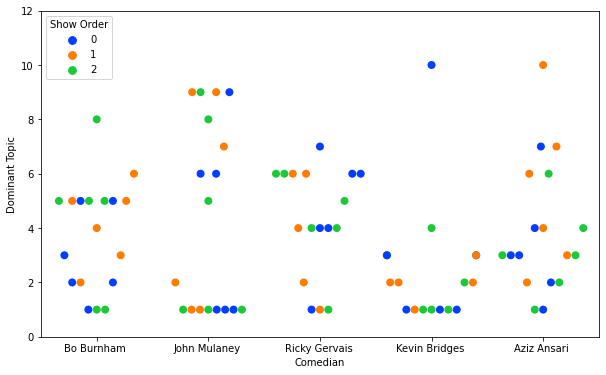

In [309]:
plt.figure(figsize = (10,6))
axs = sns.swarmplot(data=graph_df, x='Comedian', y='Dominant Topic', hue='Show_num', size=8, palette='bright')
axs.set_ylim(0,12)
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles=handles, labels=labels, title='Show Order', loc='upper left')

Unsuprisingly, a lot of the comics have Topic 1 in their top topics. Looking back at topic 1 in the pyLDAvis, we can see that topic 1 seems to refer to Family, Friends and generic story words so it makes sense that we see these crop up often.
It's more important to look at the blue dots, as these show by far the most dominant topic for each section of the comedians sketch. 
- Bo and Ricky clearly have 3 favoured topics each. 
- John is mostly focussed on two topics.
- Kevin almost exclusively focuses on a single topic.
- Aziz has the most varied sketches, which seem to focus on a wide range of topics.